In [42]:
import pandas as pd
import numpy as np

In [43]:
#Load data
file_path = "consumer-loan-portfolios-historical.csv"
df = pd.read_csv(file_path)

In [44]:
# Convert "year:Q" -> pandas quarterly period
df["Date"] = df["Date"].str.replace(":","",)
df["Date"] = pd.PeriodIndex(df["Date"],freq="Q")

#Convert to timestamp (quarter end)
df["Date"] = df["Date"].dt.to_timestamp(how="end").dt.normalize()

print(df["Date"].head())

0   2013-06-30
1   2013-09-30
2   2013-12-31
3   2014-03-31
4   2014-06-30
Name: Date, dtype: datetime64[ns]


In [45]:
#Keep date separate
id_vars = ["Date"]
value_vars = [col for col in df.columns if col != "Date"]

df_long=df.melt(id_vars = id_vars,
                value_vars = value_vars,
                var_name = "Loan_PD_Category",
                value_name = "Balance")
print(df_long.head())

        Date            Loan_PD_Category  Balance
0 2013-06-30  Credit Cards: <= 1 percent    133.5
1 2013-09-30  Credit Cards: <= 1 percent    134.9
2 2013-12-31  Credit Cards: <= 1 percent    148.0
3 2014-03-31  Credit Cards: <= 1 percent    137.1
4 2014-06-30  Credit Cards: <= 1 percent    144.9


In [46]:
# Split into Loan Type and PD Bucket
df_long[["Loan_Type", "PD_Bucket"]] = df_long["Loan_PD_Category"].str.split(": ", expand=True)

# Drop original combined column
df_long = df_long.drop(columns=["Loan_PD_Category"])

print(df_long.head())

        Date  Balance     Loan_Type     PD_Bucket
0 2013-06-30    133.5  Credit Cards  <= 1 percent
1 2013-09-30    134.9  Credit Cards  <= 1 percent
2 2013-12-31    148.0  Credit Cards  <= 1 percent
3 2014-03-31    137.1  Credit Cards  <= 1 percent
4 2014-06-30    144.9  Credit Cards  <= 1 percent


In [47]:
# Reorder columns
df_long = df_long[["Date", "Loan_Type", "PD_Bucket", "Balance"]]

print(df_long.head())

        Date     Loan_Type     PD_Bucket  Balance
0 2013-06-30  Credit Cards  <= 1 percent    133.5
1 2013-09-30  Credit Cards  <= 1 percent    134.9
2 2013-12-31  Credit Cards  <= 1 percent    148.0
3 2014-03-31  Credit Cards  <= 1 percent    137.1
4 2014-06-30  Credit Cards  <= 1 percent    144.9


In [48]:
# Standardize bucket text
df_long["PD_Bucket"] = df_long["PD_Bucket"].str.replace(" percent", "", regex=False)
df_long["PD_Bucket"] = df_long["PD_Bucket"].str.strip()

print(df_long["PD_Bucket"].unique())

['<= 1' '1.01-4' '4.01-7' '7.01-10' '10.01-14' '14.01-16' '16.01-18'
 '18.01-20' '20.01-22' '22.01-26' '26.01-30' '>30' 'Unscoreable' 'Total']


In [49]:
df_long.info()
df_long.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3500 non-null   datetime64[ns]
 1   Loan_Type  3500 non-null   object        
 2   PD_Bucket  3500 non-null   object        
 3   Balance    3500 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 109.5+ KB


,Date,Loan_Type,PD_Bucket,Balance
0,2013-06-30,Credit Cards,<= 1,133.5
1,2013-09-30,Credit Cards,<= 1,134.9
2,2013-12-31,Credit Cards,<= 1,148.0
3,2014-03-31,Credit Cards,<= 1,137.1
4,2014-06-30,Credit Cards,<= 1,144.9


In [50]:
#Exclude "Total" and Unscoreable" rows
df_long_clean = df_long[
    ~df_long["PD_Bucket"].isin(["Total", "Unscoreable"])
].copy()

print(df_long_clean["PD_Bucket"].unique())

['<= 1' '1.01-4' '4.01-7' '7.01-10' '10.01-14' '14.01-16' '16.01-18'
 '18.01-20' '20.01-22' '22.01-26' '26.01-30' '>30']


## **1.) Weighted-average probability-of-default (PD) for each loan type.**

In [51]:
# Calculate weighted-average PD for each Loan_Type by quarter,
# using PD midpoints and loan balances as weights.

# Define numeric midpoint for each PD bucket
def bucket_midpoint(bucket):
    if "<=" in bucket:
        return 0.5  # midpoint for <=1%
    if ">" in bucket:
        return 35   # approximate midpoint for >30%
    if "-" in bucket:
        low, high = bucket.split("-")
        return (float(low) + float(high)) / 2
    return np.nan

# Apply the midpoint function
df_long_clean["PD_Midpoint"] = df_long_clean["PD_Bucket"].apply(bucket_midpoint)

# Compute weighted-average PD by Loan_Type and Date
weighted_avg_pd = (
    df_long_clean
    .groupby(["Date", "Loan_Type"])
    .apply(lambda x: np.average(x["PD_Midpoint"], weights=x["Balance"]))
    .reset_index(name="Weighted_Avg_PD")
)

# Inspect results
print(weighted_avg_pd.tail())

          Date                         Loan_Type  Weighted_Avg_PD
245 2025-09-30                  Automobile Loans         3.009324
246 2025-09-30                   Consumer Leases         0.949579
247 2025-09-30                      Credit Cards         5.154546
248 2025-09-30  Other loans and revolving credit         1.888194
249 2025-09-30                     Student Loans         3.270112


C:\Users\charlestc\AppData\Local\Temp\ipykernel_14644\515007992.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x["PD_Midpoint"], weights=x["Balance"]))


### **Findings:**

The following table reports the **weighted-average porbability-of-default (PD) for each consumer loan type at the end of Q3 2025. According to the data above, **credit cards have the highest average probability-if-default (PD) at approximately 5.15%.** This indicates that, on average, credit cards carry more risk than other loan types. **Consumer leases have the lowest PD at approximately 0.95%,** reflecting relatively safer exposures. Automobile loans (3.01%), student loans (3.27%), and other loans and revolving credit (1.88%) exhibit moderate risk levles based on the distribution of loan balances across PD buckets.

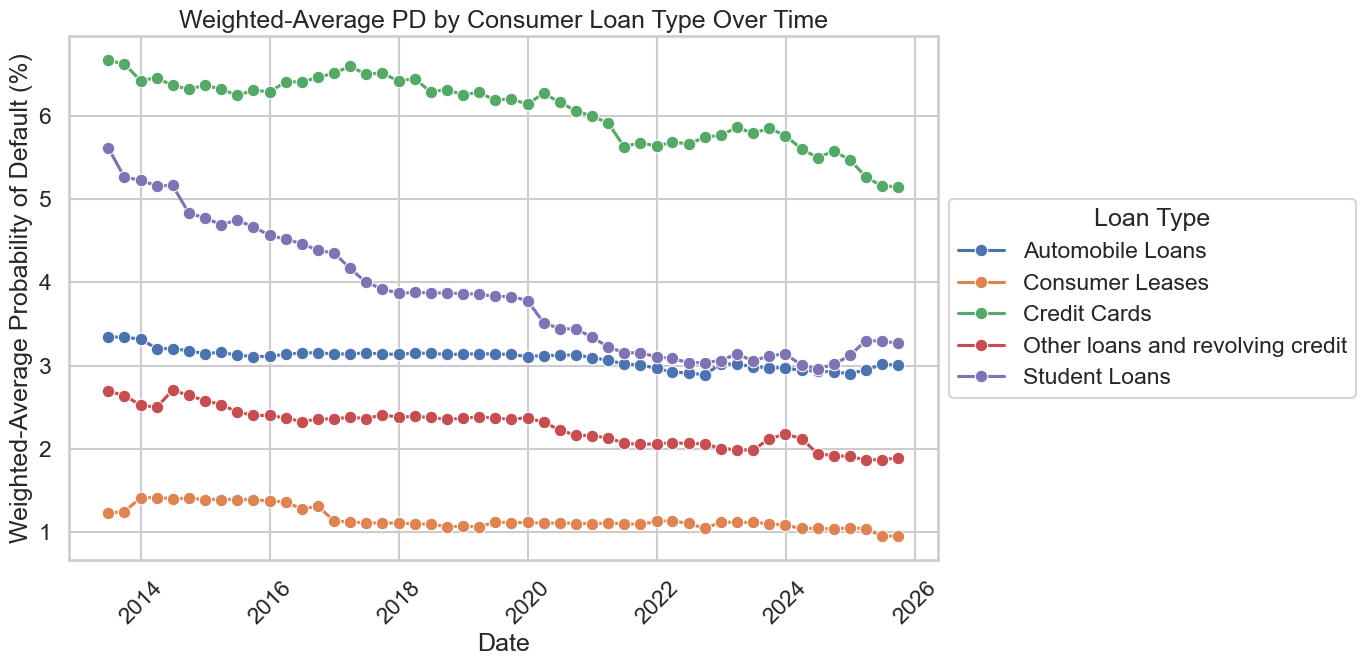

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Plot line chart
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=weighted_avg_pd, 
    x="Date", 
    y="Weighted_Avg_PD", 
    hue="Loan_Type",   # separate line for each loan type
    marker="o"
)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Weighted-Average Probability of Default (%)")
plt.title("Weighted-Average PD by Consumer Loan Type Over Time")
plt.legend(title="Loan Type")
plt.xticks(rotation=45)
# Move legend outside the plot (to the right)
plt.legend(title="Loan Type", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### **Credit Cards:**

Credit card PD steadily declined from 6.7% in mid-2013 to a low of 5.15% by late 2025, driven by a strong post-recession economic expansion with falling unemployment, rising incomes, and credit score improvements through 2019, followed by pandemic stimulus, massive debt paydowns, and record-low delinquencies around 2020–2021.

PD continued drifting lower through 2025 after a brief post-stimulus rise in the early 2020s, due to tightened bank underwriting (reducing subprime lending), slowed credit card borrowing growth since 2024, easing inflation, lower interest rates, and recent stabilization or declines in delinquency rates across segments.

### **Student Loans:**

Student loan PD fell steadily from 5.6% in mid-2013 to a low of 2.96% by mid-2024, driven by the long economic expansion through 2019, growing income-driven repayment use, and especially the 2020–2023 federal payment pause with zero interest that halted delinquencies and allowed catch-up payments.

PD has risen modestly to 3.27% by late 2025 after payments resumed in late 2023, due to the end of the on-ramp period, resumed delinquency reporting causing spikes in serious delinquencies, borrowers' disconnection from repayment habits during the pause, and some economic pressures, though widespread forbearance and administrative fixes have kept the increase limited.

### **Automobile Loans:**

Automobile loan PD remained fairly stable overall from 3.35% in mid-2013 to 3.01% by late 2025, with a gradual downward drift to a low of 2.89% in late 2022 driven by the strong economic recovery through 2019, improved borrower credit profiles, and pandemic-era stimulus plus forbearance that pushed delinquencies to historic lows in 2020–2022.

PD has shown only modest upward movement since 2023 (hovering around 2.9–3.0% through 2025), due to resumed normal payment behavior, higher interest rates on new loans, some rise in subprime auto lending earlier in the period, and recent economic pressures like inflation, though tightened underwriting and stabilizing delinquencies have kept changes limited and far smaller than in unsecured credit like credit cards or student loans.

### **Consumer Leases:**

Consumer lease PD has remained fairly stable overall from 1.23% in mid-2013 to 0.95% by late 2025, fluctuating mostly between 1.0–1.4% through the 2010s and early 2020s due to secured nature of the collateral (vehicles), conservative underwriting, strong repossession/recovery rates, and consistent economic conditions that supported borrower performance similar to auto loans.

PD showed a modest but noticeable decline to below 1.0% starting around 2024–2025, likely from tightened leasing standards post-pandemic, improved borrower credit profiles in recent years, lower delinquency rates on underlying auto-related exposures, and possibly reduced originations or shifts toward higher-quality lessees amid higher interest rates and economic moderation.

### **Other loans and Revolving Credit:**

"Other loans and revolving credit" is a miscellaneous consumer credit category that typically includes non-mortgage, non-auto, non-student, and non-traditional credit card revolving accounts, such as personal lines of credit, retail store cards (if not classified as credit cards), overdraft protection, certain unsecured personal loans, and other revolving or installment consumer debt not fitting major buckets.

Other loans and revolving credit PD declined gradually from 2.7% in mid-2013 to 1.87% by early 2025 (settling near 1.89% by late 2025), driven by the strong economic expansion through 2019 improving borrower quality, pandemic stimulus and forbearance reducing delinquencies to historic lows in 2020–2022, and ongoing credit score gains plus conservative lending in this heterogeneous segment.

PD experienced only a brief modest rise in 2023 (peaking near 2.18%) before resuming its downward trend through 2025, due to post-stimulus normalization, tightened standards reducing higher-risk originations, slowing borrowing growth amid higher rates, and stabilizing or improving delinquency metrics in residual revolving and personal loan exposures.

### **Overall:**

Consumer loan PD across major categories declined overall from mid-2013 to late 2025, primarily driven by the prolonged post-recession economic expansion through 2019 improving borrower credit quality and incomes, followed by pandemic-era stimulus, widespread forbearance, debt paydowns, and record-low delinquencies in 2020–2022 that benefited secured and unsecured lending alike.
After a modest uptick in some segments during 2023 amid post-stimulus normalization, higher interest rates, and resumed payments (notably for student loans), aggregate PD resumed drifting lower through 2025 due to tightened underwriting standards, slowed borrowing growth, easing inflation, falling rates, and stabilizing delinquency trends across most categories.

## **2.) Risk Shares Within Each Loan Type.**

In [53]:
# Compute total balance by Date and Loan_Type
total_by_type = df_long_clean.groupby(["Date", "Loan_Type"])["Balance"].transform("sum")

# Compute risk share for each PD bucket
df_long_clean["Risk_Share"] = df_long_clean["Balance"] / total_by_type

print(df_long_clean.head())                                                       

        Date     Loan_Type PD_Bucket  Balance  PD_Midpoint  Risk_Share
0 2013-06-30  Credit Cards      <= 1    133.5          0.5    0.215045
1 2013-09-30  Credit Cards      <= 1    134.9          0.5    0.215083
2 2013-12-31  Credit Cards      <= 1    148.0          0.5    0.225747
3 2014-03-31  Credit Cards      <= 1    137.1          0.5    0.219220
4 2014-06-30  Credit Cards      <= 1    144.9          0.5    0.225877


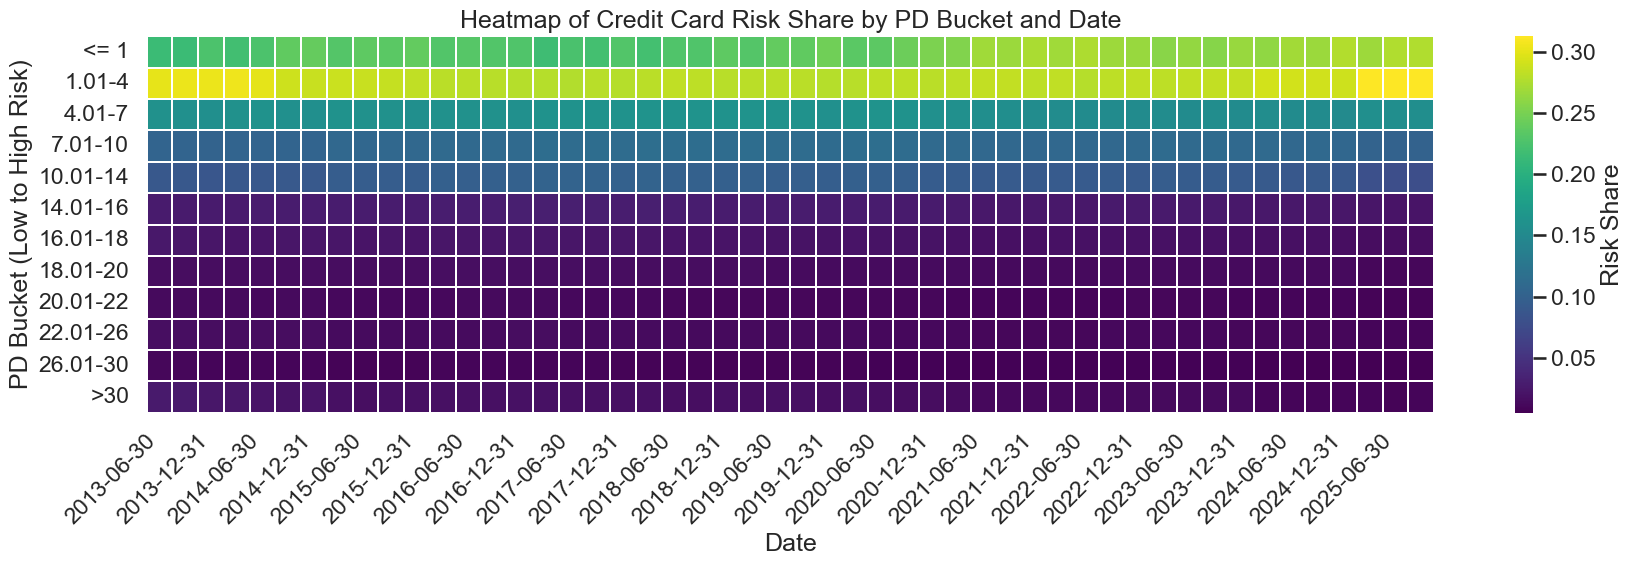

In [57]:
# Filter the main cleaned DataFrame to only Credit Cards
cc_risk = df_long_clean[df_long_clean["Loan_Type"] == "Credit Cards"]

# Create pivot table
cc_risk_heat = (cc_risk.groupby(["PD_Bucket", "Date"])["Risk_Share"].mean().unstack())

# Order PD Buckets numerically
pd_order = sorted(
    cc_risk_heat.index,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

cc_risk_heat = cc_risk_heat.reindex(pd_order)

# Clean x-axis data labels
cc_risk_heat.columns = cc_risk_heat.columns.strftime("%Y-%m-%d")

# Plot 
plt.figure(figsize=(18, 6))
sns.heatmap(
    cc_risk_heat,
    cmap="viridis",
    cbar_kws={"label": "Risk Share"},
    linewidths=0.3
)

plt.title("Heatmap of Credit Card Risk Share by PD Bucket and Date")
plt.xlabel("Date")
plt.ylabel("PD Bucket (Low to High Risk)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

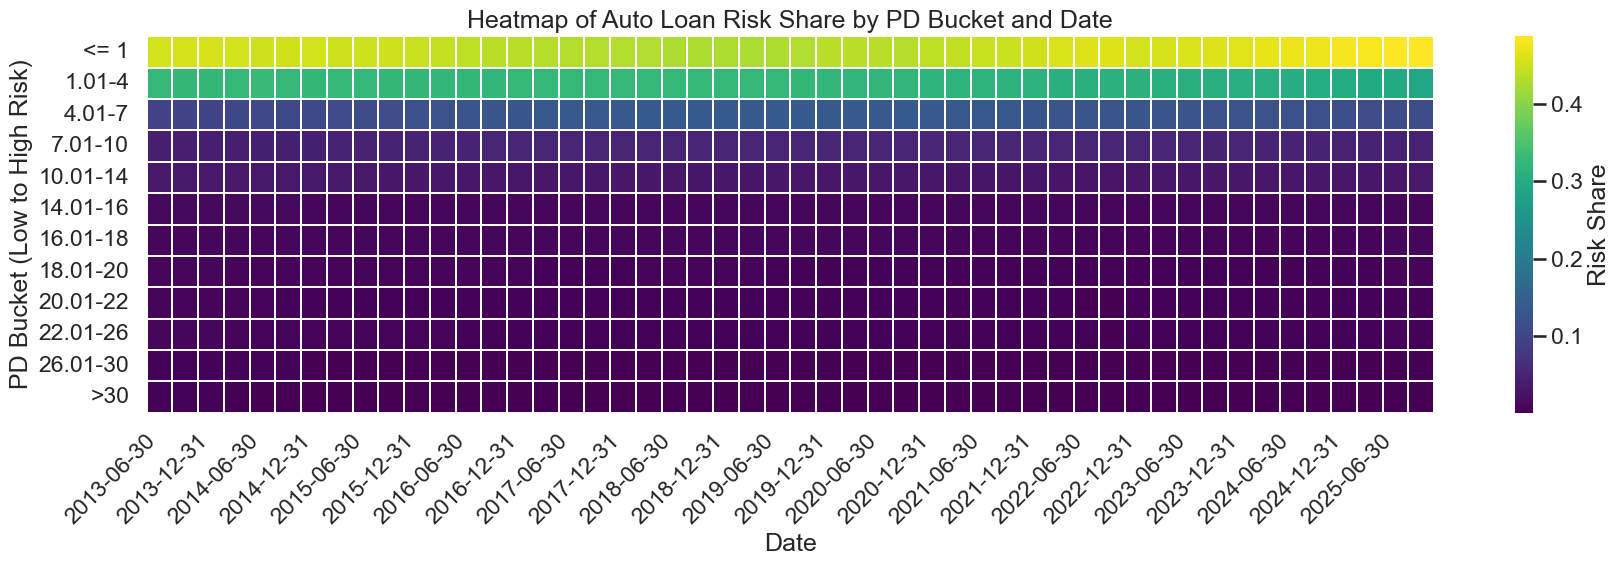

In [60]:
auto_risk = df_long_clean[df_long_clean["Loan_Type"] == "Automobile Loans"]

auto_risk_heat = (auto_risk.groupby(["PD_Bucket", "Date"])["Risk_Share"].mean().unstack())

pd_order = sorted(
    auto_risk_heat.index,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

auto_risk_heat = auto_risk_heat.reindex(pd_order)
auto_risk_heat.columns = auto_risk_heat.columns.strftime("%Y-%m-%d")

plt.figure(figsize=(18, 6))
sns.heatmap(
    auto_risk_heat,
    cmap="viridis",
    cbar_kws={"label": "Risk Share"},
    linewidths=0.3
)

plt.title("Heatmap of Auto Loan Risk Share by PD Bucket and Date")
plt.xlabel("Date")
plt.ylabel("PD Bucket (Low to High Risk)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

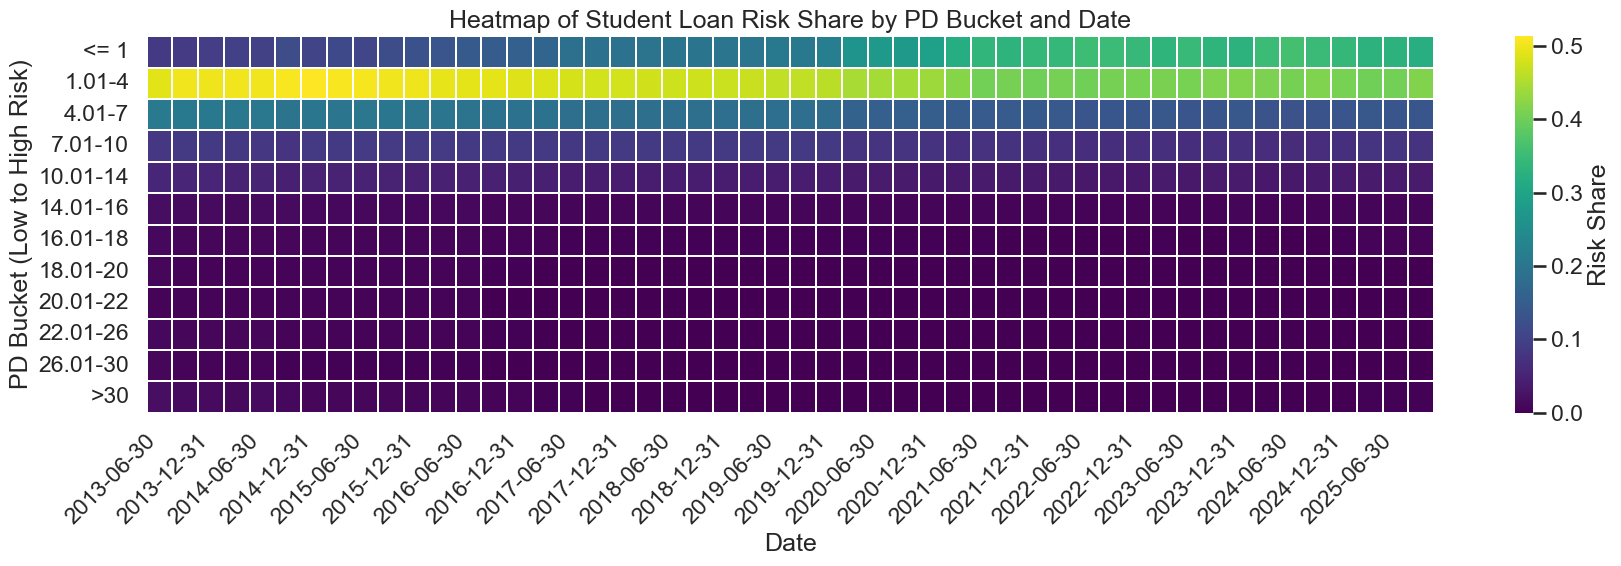

In [63]:
student_risk = df_long_clean[df_long_clean["Loan_Type"] == "Student Loans"]

student_risk_heat = (student_risk.groupby(["PD_Bucket", "Date"])["Risk_Share"].mean().unstack())

pd_order = sorted(
    student_risk_heat.index,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

student_risk_heat = student_risk_heat.reindex(pd_order)
student_risk_heat.columns = student_risk_heat.columns.strftime("%Y-%m-%d")

plt.figure(figsize=(18, 6))
sns.heatmap(
    student_risk_heat,
    cmap="viridis",
    cbar_kws={"label": "Risk Share"},
    linewidths=0.3
)

plt.title("Heatmap of Student Loan Risk Share by PD Bucket and Date")
plt.xlabel("Date")
plt.ylabel("PD Bucket (Low to High Risk)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

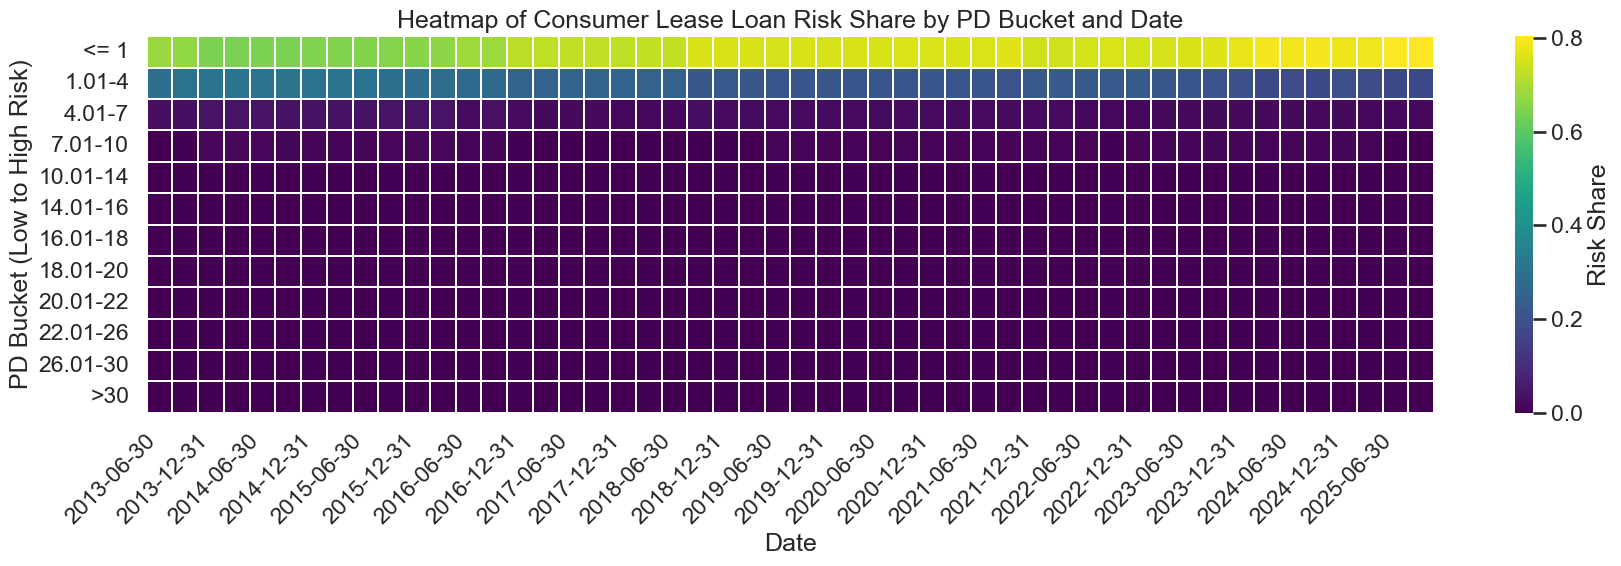

In [64]:
lease_risk = df_long_clean[df_long_clean["Loan_Type"] == "Consumer Leases"]

lease_risk_heat = (lease_risk.groupby(["PD_Bucket", "Date"])["Risk_Share"].mean().unstack())

pd_order = sorted(
    lease_risk_heat.index,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

lease_risk_heat = lease_risk_heat.reindex(pd_order)
lease_risk_heat.columns = lease_risk_heat.columns.strftime("%Y-%m-%d")

plt.figure(figsize=(18, 6))
sns.heatmap(
    lease_risk_heat,
    cmap="viridis",
    cbar_kws={"label": "Risk Share"},
    linewidths=0.3
)

plt.title("Heatmap of Consumer Lease Loan Risk Share by PD Bucket and Date")
plt.xlabel("Date")
plt.ylabel("PD Bucket (Low to High Risk)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

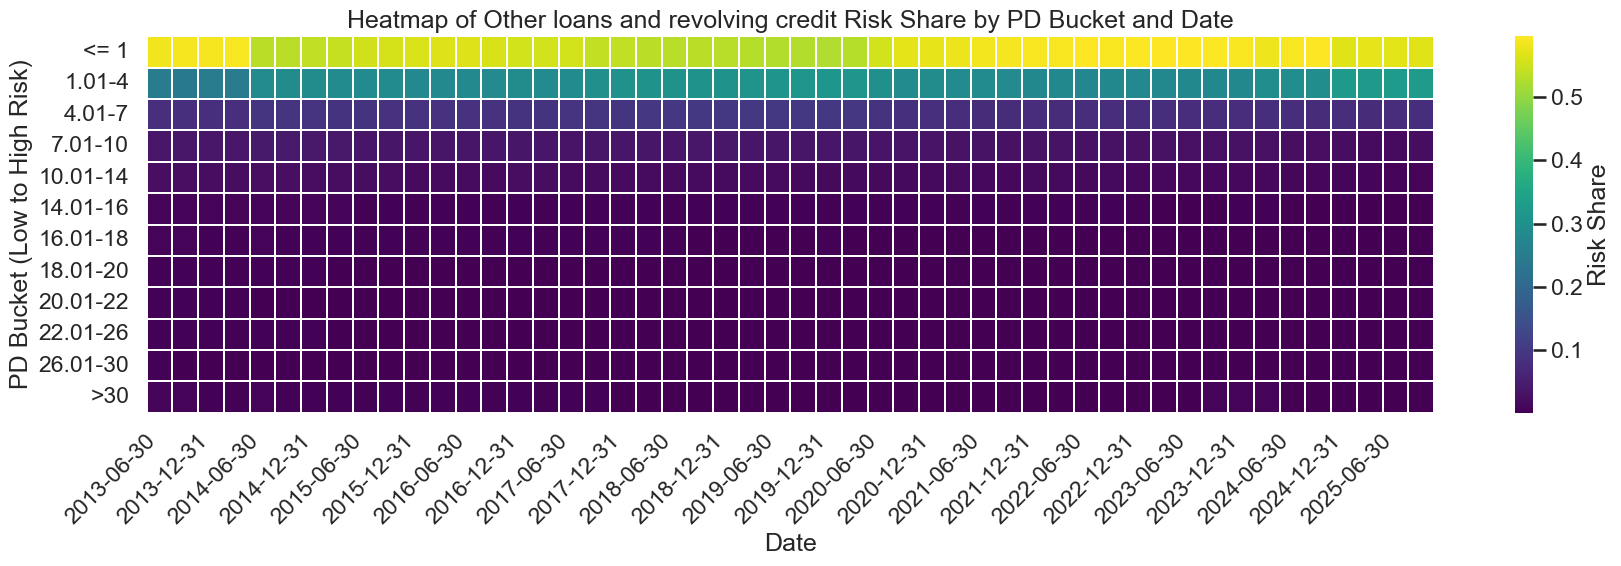

In [65]:
other_risk = df_long_clean[df_long_clean["Loan_Type"] == "Other loans and revolving credit"]

other_risk_heat = (other_risk.groupby(["PD_Bucket", "Date"])["Risk_Share"].mean().unstack())

pd_order = sorted(
    other_risk_heat.index,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

other_risk_heat = other_risk_heat.reindex(pd_order)
other_risk_heat.columns = other_risk_heat.columns.strftime("%Y-%m-%d")

plt.figure(figsize=(18, 6))
sns.heatmap(
    other_risk_heat,
    cmap="viridis",
    cbar_kws={"label": "Risk Share"},
    linewidths=0.3
)

plt.title("Heatmap of Other loans and revolving credit Risk Share by PD Bucket and Date")
plt.xlabel("Date")
plt.ylabel("PD Bucket (Low to High Risk)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### **Findings:**

The results indicate a clear inverse relationship between credit risk and portfolio composition, with lower–probability-of-default buckets consistently accounting for the largest share of outstanding balances while higher-risk buckets represent a progressively smaller portion of total credit exposure. This pattern suggests that lenders’ portfolios are concentrated in relatively safer borrowers, reflecting underwriting standards, risk-based pricing, and active credit management that limit exposure to high-default-risk accounts.

## **Consumer Credit Risk Index (CCRI).**

In [66]:
# Total balance across all loan types for each date
total_balance_by_date = df_long_clean.groupby("Date")["Balance"].transform("sum")

# Weight of each loan type in total consumer loans
df_long_clean["Loan_Type_Share"] = df_long_clean["Balance"] / total_balance_by_date

# Multiply PD_Midpoint by Risk_Share (within loan type) and Loan_Type_Share (across types)
df_long_clean["Weighted_Risk"] = df_long_clean["PD_Midpoint"] * df_long_clean["Risk_Share"] * df_long_clean["Loan_Type_Share"]

# Aggregate to get Consumer Credit Risk Index by Date
ccri = df_long_clean.groupby("Date")["Weighted_Risk"].sum().reset_index(name="CCRI")

# Inspect CCRI
print(ccri.head())

        Date      CCRI
0 2013-06-30  0.560225
1 2013-09-30  0.559690
2 2013-12-31  0.555142
3 2014-03-31  0.559455
4 2014-06-30  0.560247


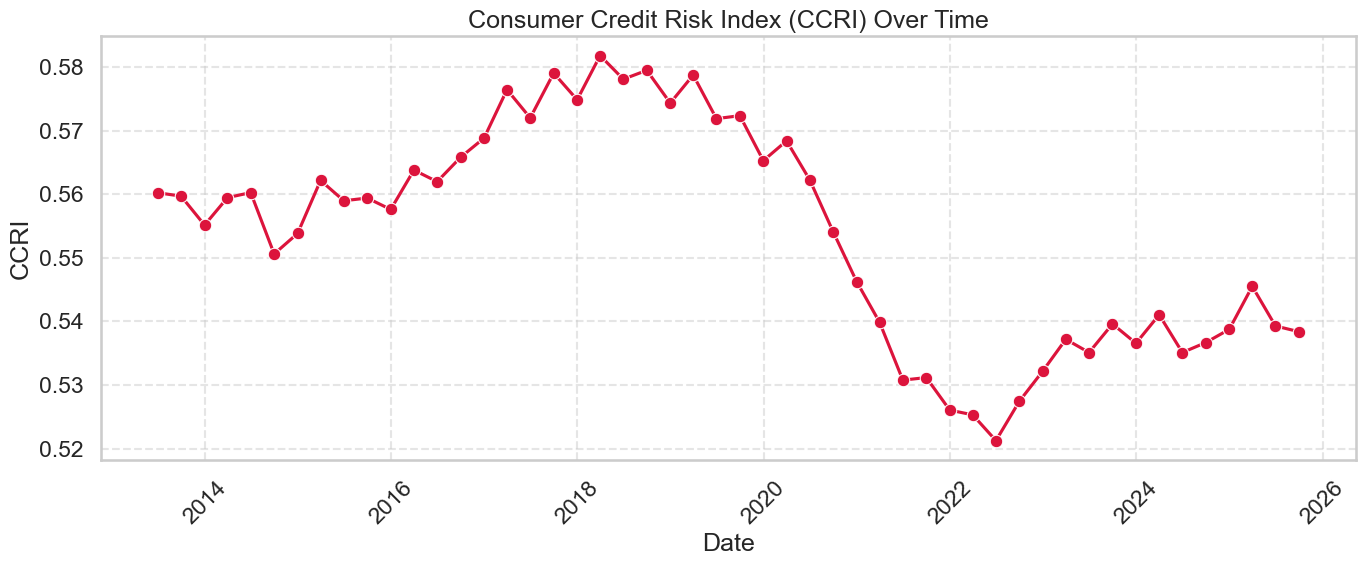

In [67]:
plt.figure(figsize=(14,6))
sns.lineplot(data=ccri, x="Date", y="CCRI", marker="o", color="crimson")
plt.title("Consumer Credit Risk Index (CCRI) Over Time")
plt.xlabel("Date")
plt.ylabel("CCRI")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

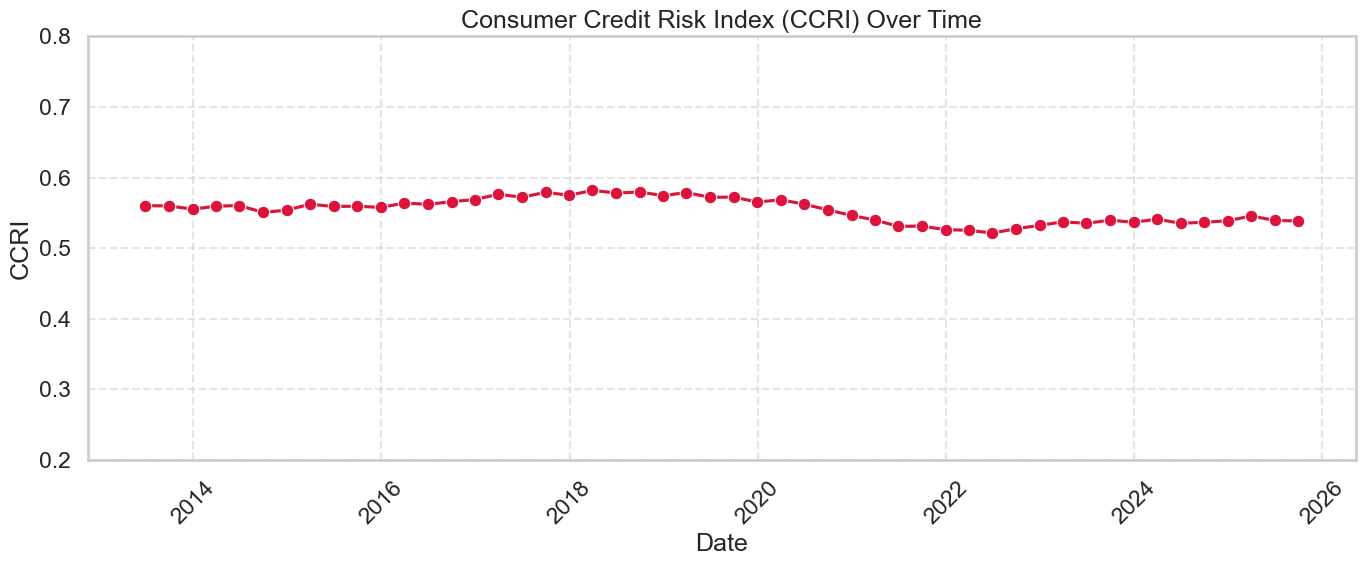

In [70]:
plt.figure(figsize=(14,6))
sns.lineplot(data=ccri, x="Date", y="CCRI", marker="o", color="crimson")
plt.title("Consumer Credit Risk Index (CCRI) Over Time")
plt.xlabel("Date")
plt.ylabel("CCRI")
# Expand y-axis range to show stability
plt.ylim(0.2, 0.8)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Findings:**

# **Problem: Credit portfolios react to risk too late.**

Credit portfolios often respond to risk signals with a lag. By the time aggregate indicators such as the CCRI or delinquency rates **signal elevated risk conditions,** underlying risk has already shifted across PD buckets, reducing the effectiveness of pricing adjustments, capital allocation, and credit tightening measures. 

**Business Challenges:**

How can lenders **identify changes in portfolio risk composition** before they materialize in realized losses or widely monitored risk indicators?

**Recommendation:**

Predict near-term PD migration and risk-share shifts. Specifically, **forecast how risk shares will migrate across PD buckets** fore each loan type over the next 1 to 4 quarters. 

This moves analysis from "what happened?" to "what is about to happen?"

## **5.) PD Migratiom (Markov) Model.**

In [72]:
credit_card = "Credit Cards"
student_loans = "Student Loans"
auto_loans = "Automobile Loans"
cons_leases = "Consumer Leases"
other_loans = "Other loans and revolving credit"

cc_loan_data = df_long_clean[df_long_clean["Loan_Type"] == credit_card].copy()

# Construct distribution matrix (Date x PD_Bucket)
dist_matrix = (
    cc_loan_data.groupby(["Date", "PD_Bucket"])["Risk_Share"].mean().unstack().fillna(0))

# Ensure PD buckets are ordered consistently (same logic you used before)
pd_order = sorted(
    dist_matrix.columns,
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

dist_matrix = dist_matrix[pd_order]
dist_matrix = dist_matrix.sort_index()

dist_matrix.head()

PD_Bucket,<= 1,1.01-4,4.01-7,7.01-10,10.01-14,14.01-16,16.01-18,18.01-20,20.01-22,22.01-26,26.01-30,>30
Date,,,,,,,,,,,,
2013-06-30,0.215045,0.300741,0.158988,0.103093,0.088756,0.027223,0.024646,0.015786,0.012887,0.016269,0.010309,0.026256
2013-09-30,0.215083,0.303890,0.158801,0.102519,0.088489,0.027105,0.024235,0.015466,0.012436,0.015944,0.009885,0.026148
2013-12-31,0.225747,0.303691,0.156955,0.101281,0.087858,0.026693,0.021965,0.015253,0.012355,0.015558,0.009304,0.023337
2014-03-31,0.219220,0.305085,0.159578,0.102814,0.088583,0.027662,0.021586,0.015350,0.012312,0.015350,0.009274,0.023185
2014-06-30,0.225877,0.299766,0.160405,0.102884,0.088698,0.028215,0.021668,0.015277,0.012159,0.015121,0.009197,0.020733


In [73]:
# Convert to numpy
S_t = dist_matrix.iloc[:-1].values
S_t1 = dist_matrix.iloc[1:].values

# Solve least squares for P
P_hat, _, _, _ = np.linalg.lstsq(S_t, S_t1, rcond=None)

# Ensure no negatives
P_hat = np.clip(P_hat, 0, None)

# Row-normalize to ensure Markov property
P_hat = P_hat / P_hat.sum(axis=1, keepdims=True)

# Convert to DataFrame for readability
transition_matrix = pd.DataFrame(
    P_hat,
    index=pd_order,
    columns=pd_order
)

transition_matrix

,<= 1,1.01-4,4.01-7,7.01-10,10.01-14,14.01-16,16.01-18,18.01-20,20.01-22,22.01-26,26.01-30,>30
<= 1,0.367132,0.166863,0.163458,0.117942,0.117099,0.024066,0.018794,0.011416,0.007721,0.001996,0.003513,0.000000
1.01-4,0.102100,0.739473,0.033239,0.064238,0.021252,0.011169,0.000000,0.009433,0.009553,0.009544,0.000000,0.000000
4.01-7,0.535581,0.000000,0.245165,0.000000,0.000000,0.018034,0.035819,0.012824,0.004081,0.019958,0.030363,0.098174
7.01-10,0.000000,0.610315,0.201483,0.188203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.01-14,0.729045,0.000000,0.000000,0.000000,0.087845,0.038231,0.010837,0.029909,0.020482,0.029790,0.017671,0.036192
14.01-16,0.000000,0.000000,0.332859,0.273388,0.257565,0.099704,0.028228,0.007036,0.001220,0.000000,0.000000,0.000000
16.01-18,0.000000,0.487459,0.000000,0.032875,0.139862,0.000000,0.143997,0.010586,0.012264,0.037798,0.005821,0.129337
18.01-20,0.000000,0.314008,0.255841,0.150958,0.125957,0.059101,0.006999,0.045327,0.011883,0.016795,0.013131,0.000000
20.01-22,0.806759,0.000000,0.000000,0.000000,0.044899,0.000000,0.034316,0.024753,0.039175,0.025341,0.005537,0.019222
22.01-26,0.000000,0.672997,0.308948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001121,0.016934


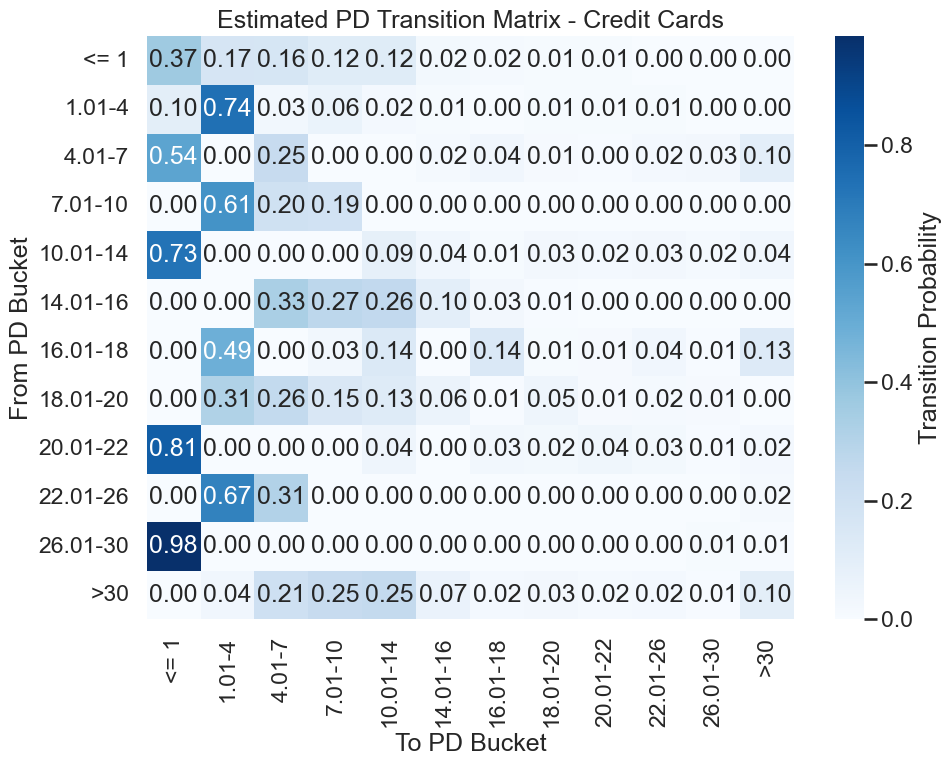

In [75]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Transition Probability"}
)

plt.title(f"Estimated PD Transition Matrix - {credit_card}")
plt.xlabel("To PD Bucket")
plt.ylabel("From PD Bucket")
plt.tight_layout()
plt.show()

In [76]:
# Take last observed distribution
last_dist = dist_matrix.iloc[-1].values

# Forecast next quarter
forecast_next = last_dist @ P_hat

forecast_df = pd.DataFrame(
    [last_dist, forecast_next],
    index=["Current", "Forecast"],
    columns=pd_order
)

forecast_df

,<= 1,1.01-4,4.01-7,7.01-10,10.01-14,14.01-16,16.01-18,18.01-20,20.01-22,22.01-26,26.01-30,>30
Current,0.276567,0.312618,0.156399,0.099991,0.077661,0.021254,0.014797,0.010403,0.007712,0.008788,0.005022,0.008788
Forecast,0.284996,0.355052,0.128355,0.081543,0.057274,0.019245,0.014905,0.011653,0.008127,0.010071,0.007478,0.021302


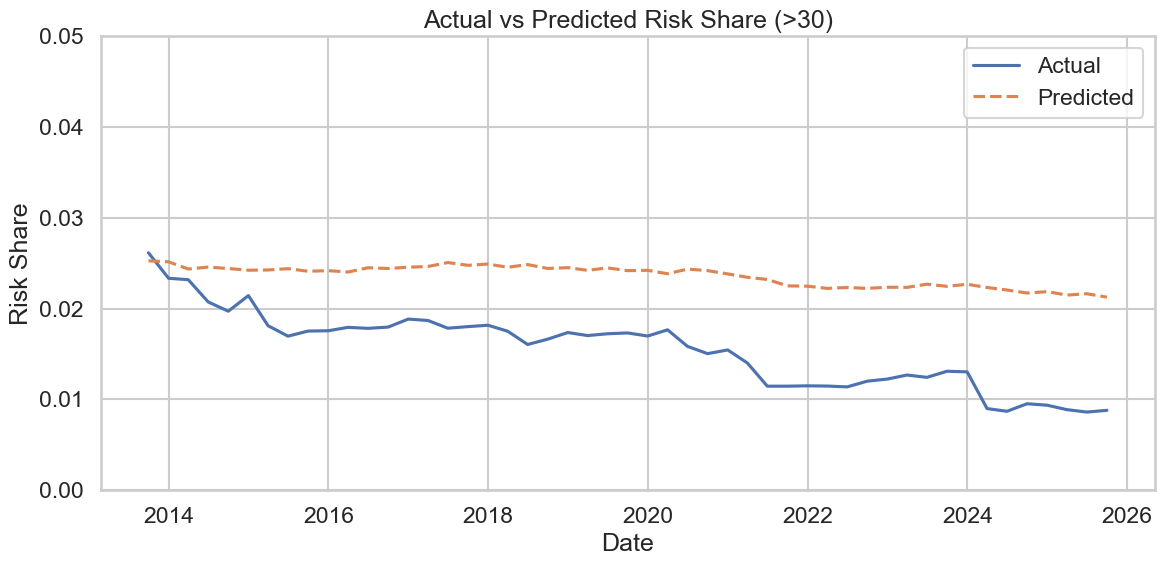

In [104]:
predicted = S_t @ P_hat

predicted_df = pd.DataFrame(
    predicted,
    index=dist_matrix.index[1:],
    columns=pd_order
)

# Plot actual vs predicted for highest PD bucket
bucket_to_plot = pd_order[-1]

plt.figure(figsize=(12,6))
plt.plot(dist_matrix.index[1:], dist_matrix[bucket_to_plot].iloc[1:], label="Actual")
plt.plot(predicted_df.index, predicted_df[bucket_to_plot], linestyle="--", label="Predicted")

plt.title(f"Actual vs Predicted Risk Share ({bucket_to_plot})")
plt.xlabel("Date")
plt.ylabel("Risk Share")
plt.ylim(0.0, 0.05)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
pd_order = sorted(
    df_long_clean["PD_Bucket"].unique(),
    key=lambda x: (
        float(x.split("-")[0]) if "-" in x
        else float(x.replace("<=", "").replace(">", ""))
    )
)

In [91]:
pd_dist = (
    df_long_clean
    .groupby(["Date", "PD_Bucket"])["Risk_Share"]
    .sum()
    .unstack(fill_value=0)
    .reindex(columns=pd_order)
)

In [92]:
train_end = "2021-12-31"

train_dist = pd_dist.loc[pd_dist.index <= train_end]
test_dist  = pd_dist.loc[pd_dist.index > train_end]

In [93]:
transition_counts = np.zeros((len(pd_order), len(pd_order)))

for t in range(len(train_dist) - 1):
    current = train_dist.iloc[t].values
    next_   = train_dist.iloc[t + 1].values
    transition_counts += np.outer(current, next_)

transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)

transition_matrix = pd.DataFrame(
    transition_matrix,
    index=pd_order,
    columns=pd_order
)

In [94]:
predicted = []

current_state = train_dist.iloc[-1].values

for _ in range(len(test_dist)):
    next_state = current_state @ transition_matrix.values
    predicted.append(next_state)
    current_state = next_state

predicted_dist = pd.DataFrame(
    predicted,
    index=test_dist.index,
    columns=pd_order
)

In [95]:
mae = (predicted_dist - test_dist).abs().mean().mean()
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.0508


In [96]:
rmse = np.sqrt(((predicted_dist - test_dist) ** 2).mean().mean())
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0988


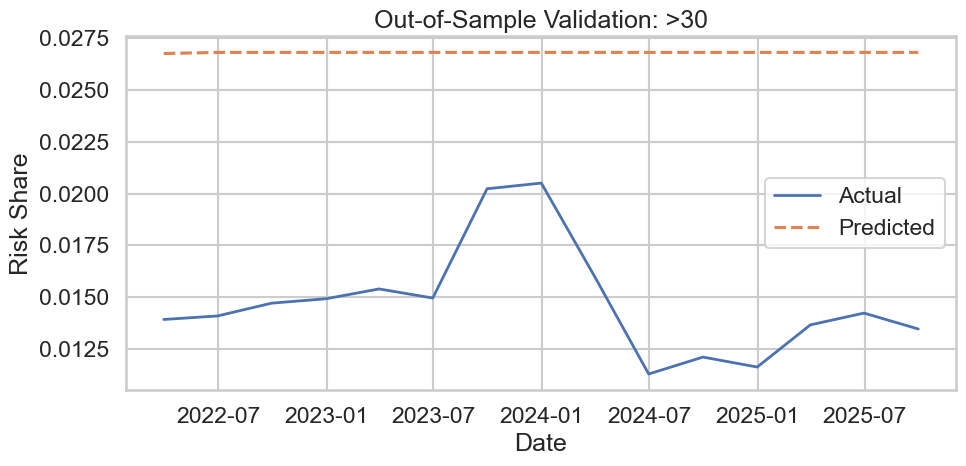

In [99]:
high_risk_bucket = pd_order[-1]

plt.figure(figsize=(10, 5))
plt.plot(test_dist.index, test_dist[high_risk_bucket], label="Actual", linewidth=2)
plt.plot(predicted_dist.index, predicted_dist[high_risk_bucket], label="Predicted", linestyle="--")

plt.title(f"Out-of-Sample Validation: {high_risk_bucket}")
plt.ylabel("Risk Share")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()